In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset, Dataset
import torchaudio
import os
from itertools import islice
import numpy as np
from torch import nn
# Set up device and mixed precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = True if torch.cuda.is_available() else False
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Load the Whisper Tiny processor and model
model_name = "openai/whisper-tiny"  
processor = WhisperProcessor.from_pretrained(model_name)
whisper_model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)

# Load the dataset again
dataset_name = "librispeech_asr"
subset = "clean"
split = "train.100"

librispeech_dataset = load_dataset(dataset_name, subset, split=split, streaming=True)

# Define the dataset class again (same as before)
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset
import torchaudio
from itertools import islice

# Set up device and mixed precision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = True if torch.cuda.is_available() else False
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Load the Whisper Tiny processor and model
model_name = "openai/whisper-tiny"  
processor = WhisperProcessor.from_pretrained(model_name)
whisper_model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)

# Load the dataset
dataset_name = "librispeech_asr"
subset = "clean"
split = "train.100"

librispeech_dataset = load_dataset(dataset_name, subset, split=split, streaming=True)

class LibriSpeechDataset(Dataset):
    def __init__(self, dataset, processor, max_samples=1000):
        self.dataset = dataset
        self.processor = processor
        self.max_samples = max_samples
        self.data_iterator = iter(self.dataset)

    def __len__(self):
        return self.max_samples

    def __getitem__(self, idx):
        try:
            sample = next(self.data_iterator)
        except StopIteration:
            # Restart the iterator if we've reached the end
            self.data_iterator = iter(self.dataset)
            sample = next(self.data_iterator)

        return self.process_sample(sample)

    def process_sample(self, sample):
        speech_array = sample['audio']['array']
        sampling_rate = sample['audio']['sampling_rate']

        if sampling_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
            speech_array = resampler(torch.from_numpy(speech_array).float()).numpy()

        if speech_array.ndim > 1:
            speech_array = speech_array.mean(axis=0)

        input_features = self.processor(speech_array, sampling_rate=16000, return_tensors="pt").input_features

        return input_features.squeeze(0)

# Instantiate the dataset
num_samples = 100  # Use a small number for quick calculation
dataset = LibriSpeechDataset(librispeech_dataset, processor, max_samples=num_samples)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=1, num_workers=0, pin_memory=True)

# Get a batch of data to determine dimensions
sample_batch = next(iter(dataloader))

print(f"Sample batch shape: {sample_batch.shape}")

# Now you can continue with the rest of your code...
# For example, to extract Whisper features:
with torch.no_grad():
    sample_batch = sample_batch.to(device)
    outputs = whisper_model.model.encoder(sample_batch)
    encoder_features = outputs.last_hidden_state

print(f"Encoder features shape: {encoder_features.shape}")

# Get the decoder features
batch_size = sample_batch.size(0)
decoder_input_ids = torch.full((batch_size, 1), whisper_model.config.decoder_start_token_id, dtype=torch.long, device=device)
decoder_outputs = whisper_model.model.decoder(
    input_ids=decoder_input_ids,
    encoder_hidden_states=encoder_features
)
decoder_features = decoder_outputs.last_hidden_state

print(f"Decoder features shape: {decoder_features.shape}")

# Determine input dimensions for the encoder SAE
encoder_input_dim = encoder_features.shape[-1]
# Determine input dimensions for the decoder SAE
decoder_input_dim = decoder_features.shape[-1]

# Now we have the required dimensions
print(f"Encoder Input Dimension: {encoder_input_dim}")
print(f"Decoder Input Dimension: {decoder_input_dim}")

# Load the trained SAE models
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return encoded, decoded

hidden_dim = 1152  # This should match the dimension used during training

# Instantiate models
encoder_sae = SparseAutoencoder(encoder_input_dim, hidden_dim).to(device)
decoder_sae = SparseAutoencoder(decoder_input_dim, hidden_dim).to(device)

# Load trained weights
encoder_sae.load_state_dict(torch.load("encoder_sae_tiny_100k_1152_space.pth"))
decoder_sae.load_state_dict(torch.load("decoder_sae_tiny_100k_1152_space.pth"))

# Now, all variables are set up and models are loaded!


/tmp/ipykernel_61929/1570913153.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


/tmp/ipykernel_61929/1570913153.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Sample batch shape: torch.Size([1, 80, 3000])
Encoder features shape: torch.Size([1, 1500, 384])
Decoder features shape: torch.Size([1, 1, 384])
Encoder Input Dimension: 384
Decoder Input Dimension: 384


/tmp/ipykernel_61929/1570913153.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder_sae.load_state_dict(torch.load("encoder_sae_tiny_100k_1152_space.pth"))
/tmp/ip

<All keys matched successfully>

In [3]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
def extract_encoded_features(dataloader, whisper_model, sae, is_encoder=True):
    encoded_features = []
    original_features = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting encoded features"):
            batch = batch.to(device)
            
            if is_encoder:
                # Process through Whisper encoder
                whisper_features = whisper_model.model.encoder(batch).last_hidden_state  # Shape: [1, 1500, 384]
                # We'll process each time step separately
                for t in range(whisper_features.size(1)):
                    features = whisper_features[:, t, :]  # Shape: [1, 384]
                    encoded, _ = sae(features)
                    encoded_features.append(encoded.cpu().numpy())
                    original_features.append(features.cpu().numpy())
            else:
                # Process through Whisper encoder and decoder
                encoder_output = whisper_model.model.encoder(batch).last_hidden_state
                decoder_input_ids = torch.full((batch.size(0), 1), whisper_model.config.decoder_start_token_id, dtype=torch.long, device=device)
                decoder_output = whisper_model.model.decoder(
                    input_ids=decoder_input_ids,
                    encoder_hidden_states=encoder_output
                ).last_hidden_state  # Shape: [1, 1, 384]
                features = decoder_output.squeeze(1)  # Shape: [1, 384]
                encoded, _ = sae(features)
                encoded_features.append(encoded.cpu().numpy())
                original_features.append(features.cpu().numpy())

    return np.array(original_features), np.array(encoded_features)

# Use the updated function
original_encoder_features, encoded_encoder_features = extract_encoded_features(dataloader, whisper_model, encoder_sae, is_encoder=True)
original_decoder_features, encoded_decoder_features = extract_encoded_features(dataloader, whisper_model, decoder_sae, is_encoder=False)

# Visualization function
def visualize_features(original, encoded, title, max_samples=5):
    samples = min(len(original), max_samples)
    fig, axes = plt.subplots(2, samples, figsize=(20, 8))
    
    for i in range(samples):
        im1 = axes[0, i].imshow(original[i], aspect='auto', cmap='viridis')
        axes[0, i].set_title(f"Original {i+1}")
        fig.colorbar(im1, ax=axes[0, i])
        
        im2 = axes[1, i].imshow(encoded[i], aspect='auto', cmap='viridis')
        axes[1, i].set_title(f"Encoded {i+1}")
        fig.colorbar(im2, ax=axes[1, i])
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Print statistics function
def print_feature_stats(original, encoded, title):
    print(f"\n{title}:")
    print(f"Original shape: {original.shape}")
    print(f"Encoded shape: {encoded.shape}")
    print(f"Sparsity: {(encoded == 0).mean():.2%}")
    print(f"Mean activation: {encoded.mean():.4f}")
    print(f"Std deviation: {encoded.std():.4f}")
print(len(original_encoder_features))
# Visualize and print statistics
visualize_features(original_encoder_features, encoded_encoder_features, "Encoder Features")
print_feature_stats(original_encoder_features, encoded_encoder_features, "Encoder Features")

visualize_features(original_decoder_features, encoded_decoder_features, "Decoder Features")
print_feature_stats(original_decoder_features, encoded_decoder_features, "Decoder Features")

NameError: name 'original_encoder_features' is not defined

In [63]:
import torch
from torch.utils.data import DataLoader
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset
import torchaudio
from tqdm import tqdm
import os
from itertools import islice
import numpy as np
import torch.nn as nn


# Set the models to evaluation mode
whisper_model.eval()
encoder_sae.eval()
decoder_sae.eval()

# # Lists to store the encoded features
encoder_encoded_features_list = []
decoder_encoded_features_list = []

# Disable gradient computation
with torch.no_grad():
    for batch in tqdm(dataloader, desc="Processing batches"):
        batch = batch.to(device)
        
        # Get encoder outputs
        encoder_outputs = whisper_model.model.encoder(batch)
        encoder_features = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, encoder_dim]
        
        # Flatten the encoder features
        encoder_features_flat = encoder_features.view(-1, encoder_features.shape[-1])  # [batch_size * seq_len, encoder_dim]
        
        # Pass through the encoder SAE
        encoder_encoded, _ = encoder_sae(encoder_features_flat)  # [batch_size * seq_len, hidden_dim]
        encoder_encoded_features_list.append(encoder_encoded.cpu())
        
        # Prepare decoder input IDs
        batch_size = batch.size(0)
        decoder_input_ids = torch.full(
            (batch_size, 1), whisper_model.config.decoder_start_token_id, dtype=torch.long, device=device
        )
        
        # Get decoder outputs
        decoder_outputs = whisper_model.model.decoder(
            input_ids=decoder_input_ids,
            encoder_hidden_states=encoder_features
        )
        decoder_features = decoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, decoder_dim]
        
        # Flatten the decoder features
        decoder_features_flat = decoder_features.view(-1, decoder_features.shape[-1])  # [batch_size * seq_len, decoder_dim]
        
        # Pass through the decoder SAE
        decoder_encoded, _ = decoder_sae(decoder_features_flat)  # [batch_size * seq_len, hidden_dim]
        decoder_encoded_features_list.append(decoder_encoded.cpu())

# Concatenate all encoded features
encoder_encoded_features = torch.cat(encoder_encoded_features_list, dim=0)
decoder_encoded_features = torch.cat(decoder_encoded_features_list, dim=0)

print(f"Encoder encoded features shape: {encoder_encoded_features.shape}")
print(f"Decoder encoded features shape: {decoder_encoded_features.shape}")


Processing batches: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]

Encoder encoded features shape: torch.Size([150000, 128])
Decoder encoded features shape: torch.Size([100, 128])


In [64]:
def calculate_sparsity(tensor, threshold=1e-5):
    total_elements = tensor.numel()
    zero_elements = (tensor.abs() < threshold).sum().item()
    sparsity = zero_elements / total_elements
    return sparsity

encoder_sparsity = calculate_sparsity(encoder_encoded_features)
decoder_sparsity = calculate_sparsity(decoder_encoded_features)

print(f"Encoder Encoded Features Sparsity: {encoder_sparsity * 100:.2f}%")
print(f"Decoder Encoded Features Sparsity: {decoder_sparsity * 100:.2f}%")


Encoder Encoded Features Sparsity: 24.07%
Decoder Encoded Features Sparsity: 70.96%


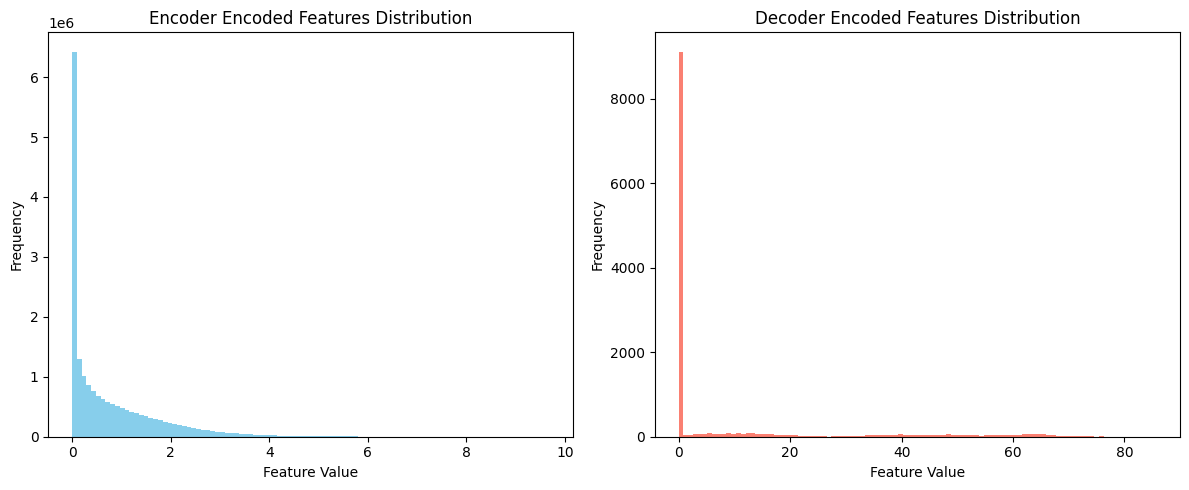

In [65]:
import matplotlib.pyplot as plt

# Convert tensors to NumPy arrays
encoder_encoded_np = encoder_encoded_features.numpy()
decoder_encoded_np = decoder_encoded_features.numpy()

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(encoder_encoded_np.flatten(), bins=100, color='skyblue')
plt.title('Encoder Encoded Features Distribution')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(decoder_encoded_np.flatten(), bins=100, color='salmon')
plt.title('Decoder Encoded Features Distribution')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


/opt/conda/envs/audio_project/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


/opt/conda/envs/audio_project/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


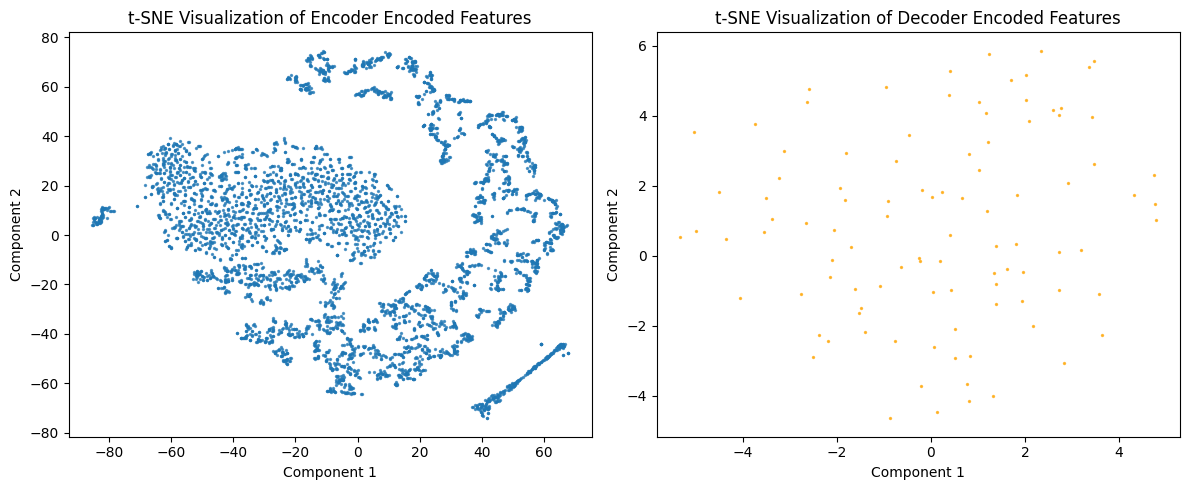

In [66]:
from sklearn.manifold import TSNE

# Sample a subset for visualization (optional)
num_samples = 5000
num_samples_decoder = 100  # Adjust based on computational resources
encoder_sample_indices = np.random.choice(encoder_encoded_np.shape[0], num_samples, replace=False)
decoder_sample_indices = np.random.choice(decoder_encoded_np.shape[0], num_samples_decoder, replace=False)

encoder_sample = encoder_encoded_np[encoder_sample_indices]
decoder_sample = decoder_encoded_np[decoder_sample_indices]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

encoder_tsne = tsne.fit_transform(encoder_sample)
decoder_tsne = tsne.fit_transform(decoder_sample)

# Plot the t-SNE results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(encoder_tsne[:, 0], encoder_tsne[:, 1], s=2, alpha=0.7)
plt.title('t-SNE Visualization of Encoder Encoded Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(1, 2, 2)
plt.scatter(decoder_tsne[:, 0], decoder_tsne[:, 1], s=2, alpha=0.7, color='orange')
plt.title('t-SNE Visualization of Decoder Encoded Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.tight_layout()
plt.show()


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the number of clusters
n_clusters = 5  # Adjust based on your analysis

# Perform K-Means clustering on encoder features
kmeans_encoder = KMeans(n_clusters=n_clusters, random_state=42)
encoder_labels = kmeans_encoder.fit_predict(encoder_sample)

# Perform K-Means clustering on decoder features
kmeans_decoder = KMeans(n_clusters=n_clusters, random_state=42)
decoder_labels = kmeans_decoder.fit_predict(decoder_sample)

# Calculate silhouette scores
encoder_silhouette = silhouette_score(encoder_sample, encoder_labels)
decoder_silhouette = silhouette_score(decoder_sample, decoder_labels)

print(f"Encoder Features Silhouette Score: {encoder_silhouette:.3f}")
print(f"Decoder Features Silhouette Score: {decoder_silhouette:.3f}")

# Plot clustering results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(encoder_tsne[:, 0], encoder_tsne[:, 1], c=encoder_labels, cmap='tab10', s=2)
plt.title('K-Means Clustering of Encoder Encoded Features')

plt.subplot(1, 2, 2)
plt.scatter(decoder_tsne[:, 0], decoder_tsne[:, 1], c=decoder_labels, cmap='tab10', s=2)
plt.title('K-Means Clustering of Decoder Encoded Features')

plt.tight_layout()
plt.show()


NameError: name 'encoder_sample' is not defined

In [5]:
import seaborn as sns

# Compute correlation matrices
encoder_corr = np.corrcoef(encoder_encoded_np.T)
decoder_corr = np.corrcoef(decoder_encoded_np.T)

# Plot heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(encoder_corr, cmap='coolwarm')
plt.title('Correlation Matrix of Encoder Encoded Features')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(decoder_corr, cmap='coolwarm')
plt.title('Correlation Matrix of Decoder Encoded Features')
plt.show()


NameError: name 'encoder_encoded_np' is not defined

In [6]:
from sklearn.decomposition import PCA

# Apply PCA
pca_encoder = PCA(n_components=2)
encoder_pca = pca_encoder.fit_transform(encoder_sample)

pca_decoder = PCA(n_components=2)
decoder_pca = pca_decoder.fit_transform(decoder_sample)

# Plot PCA results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(encoder_pca[:, 0], encoder_pca[:, 1], s=2, alpha=0.7)
plt.title('PCA of Encoder Encoded Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.subplot(1, 2, 2)
plt.scatter(decoder_pca[:, 0], decoder_pca[:, 1], s=2, alpha=0.7, color='green')
plt.title('PCA of Decoder Encoded Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()


NameError: name 'encoder_sample' is not defined

In [70]:
# Load the Common Voice dataset for English
common_voice_dataset = load_dataset("mozilla-foundation/common_voice_11_0", "en", split="train", streaming=True)


In [71]:
# Filter out samples without gender labels
def filter_gender(sample):
    return sample.get('gender') is not None and sample['gender'] != ''

labeled_dataset = common_voice_dataset.filter(filter_gender)


In [72]:
# Take a manageable subset for analysis
num_samples = 1000  # Adjust based on computational resources
labeled_dataset = labeled_dataset.take(num_samples)


In [73]:
class LabeledSpeechDataset(Dataset):
    def __init__(self, dataset, processor):
        self.processor = processor
        self.dataset = list(dataset)  # Convert streaming dataset to a list
        self.samples = self.load_samples()
    
    def load_samples(self):
        samples = []
        for sample in tqdm(self.dataset, desc="Processing samples"):
            processed_sample = self.process_sample(sample)
            if processed_sample is not None:
                samples.append(processed_sample)
        return samples
    
    def process_sample(self, sample):
        try:
            speech_array = sample['audio']['array']
            sampling_rate = sample['audio']['sampling_rate']
            label = sample['gender']
            
            # Resample if necessary
            if sampling_rate != 16000:
                resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
                speech_array = resampler(torch.from_numpy(speech_array).float()).numpy()
            
            # Handle multi-channel audio
            if speech_array.ndim > 1:
                speech_array = speech_array.mean(axis=0)
            
            # Process the audio
            input_features = self.processor(speech_array, sampling_rate=16000, return_tensors="pt").input_features
            
            return {'input_features': input_features.squeeze(0), 'label': label}
        except Exception as e:
            # Handle exceptions (e.g., corrupted audio)
            print(f"Error processing sample: {e}")
            return None
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        return sample['input_features'], sample['label']


In [74]:
dataset = LabeledSpeechDataset(labeled_dataset, processor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


Reading metadata...: 948736it [00:14, 66834.53it/s]
Processing samples: 100%|██████████| 1000/1000 [00:15<00:00, 65.86it/s]


In [75]:
encoder_encoded_features_list = []
decoder_encoded_features_list = []
labels_list = []
with torch.no_grad():
    for input_features, label in tqdm(dataloader, desc="Extracting features"):
        input_features = input_features.to(device)  # Shape: [1, feature_dim, seq_len]

        # Pass through Whisper encoder
        encoder_outputs = whisper_model.model.encoder(input_features)
        encoder_features = encoder_outputs.last_hidden_state  # Shape: [1, seq_len, encoder_dim]

        # Flatten the encoder features
        encoder_features_flat = encoder_features.view(-1, encoder_input_dim)  # Shape: [seq_len, encoder_dim]

        # Pass through the encoder SAE
        encoder_encoded, _ = encoder_sae(encoder_features_flat)  # Shape: [seq_len, hidden_dim]
        encoder_encoded_features_list.append(encoder_encoded.cpu())

        # Prepare decoder input IDs (assuming decoder analysis is needed)
        decoder_input_ids = torch.full(
            (1, 1), whisper_model.config.decoder_start_token_id, dtype=torch.long, device=device
        )

        # Pass through Whisper decoder
        decoder_outputs = whisper_model.model.decoder(
            input_ids=decoder_input_ids,
            encoder_hidden_states=encoder_features
        )
        decoder_features = decoder_outputs.last_hidden_state  # Shape: [1, seq_len, decoder_dim]

        # Flatten the decoder features
        decoder_features_flat = decoder_features.view(-1, decoder_input_dim)  # Shape: [seq_len, decoder_dim]

        # Pass through the decoder SAE
        decoder_encoded, _ = decoder_sae(decoder_features_flat)  # Shape: [seq_len, hidden_dim]
        decoder_encoded_features_list.append(decoder_encoded.cpu())

        # Collect labels (repeat labels to match the number of time steps)
        seq_len = encoder_encoded.shape[0]
        labels_list.extend([label[0]] * seq_len)  # label is a list with one element



Extracting features: 100%|██████████| 1000/1000 [07:25<00:00,  2.24it/s]


In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


In [77]:

encoder_encoded_features = torch.cat(encoder_encoded_features_list, dim=0)  # Shape: [total_seq_len, hidden_dim]
labels_array = np.array(labels_list)  # Shape: [total_seq_len]
unique_labels = np.unique(labels_array)
print(f"Unique labels: {unique_labels}")


Unique labels: ['female' 'male' 'other']


In [78]:
valid_indices = np.isin(labels_array, ['male', 'female'])
encoder_features_filtered = encoder_encoded_features[valid_indices]
labels_filtered = labels_array[valid_indices]


In [79]:
le = LabelEncoder()
encoded_labels = le.fit_transform(labels_filtered)  # 'female'->0, 'male'->1
features_np = encoder_features_filtered.numpy()



    Feature Index  T-statistic        P-value
6               6   -34.966289  2.290838e-267
29             29   -30.414162  6.885106e-203
8               8   -26.870189  7.286581e-159
32             32   -22.052866  1.075846e-107
49             49    20.559952   7.172213e-94
20             20    18.752590   2.022046e-78
9               9   -18.371585   2.421071e-75
36             36   -18.351778   3.482108e-75
21             21    17.487509   1.915110e-68
73             73    17.138731   8.141655e-66


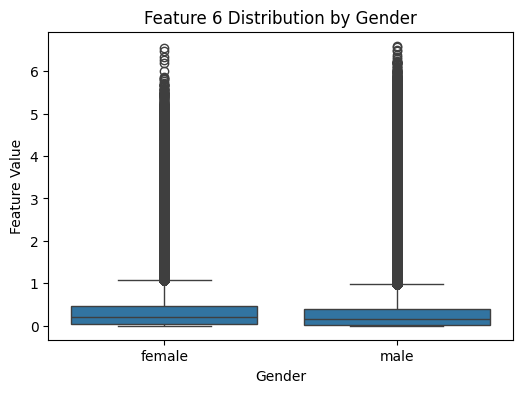

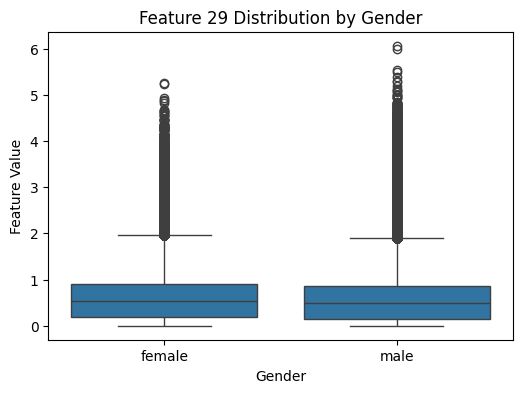

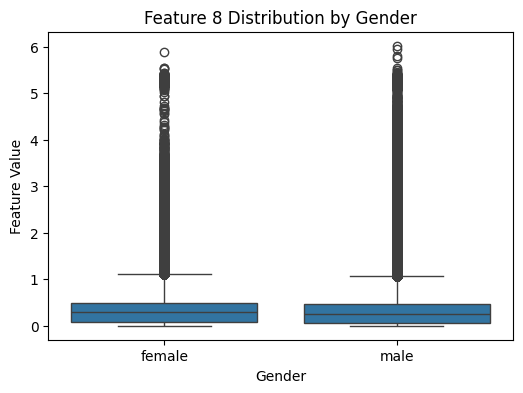

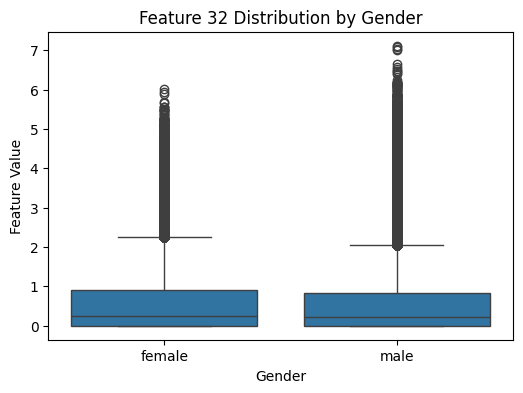

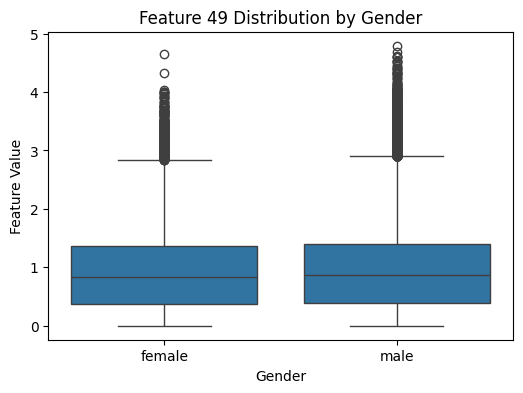

In [80]:
male_indices = encoded_labels == 1
female_indices = encoded_labels == 0

t_statistics = []
p_values = []

for i in range(features_np.shape[1]):
    male_feature_values = features_np[male_indices, i]
    female_feature_values = features_np[female_indices, i]
    t_stat, p_value = ttest_ind(male_feature_values, female_feature_values, equal_var=False)
    t_statistics.append(t_stat)
    p_values.append(p_value)

# Create a DataFrame to display results
t_test_df = pd.DataFrame({
    'Feature Index': range(features_np.shape[1]),
    'T-statistic': t_statistics,
    'P-value': p_values
})

# Sort by p-value
t_test_df = t_test_df.sort_values('P-value')
print(t_test_df.head(10))  # Display top 10 features with lowest p-values
top_features = t_test_df['Feature Index'].values[:5]  # Top 5 features

for feature_index in top_features:
    df = pd.DataFrame({
        'Feature Value': features_np[:, feature_index],
        'Gender': le.inverse_transform(encoded_labels)
    })
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Gender', y='Feature Value', data=df)
    plt.title(f'Feature {feature_index} Distribution by Gender')
    plt.show()


In [81]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_np, encoded_labels, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
# Use a subset of the training data
X_train_small = X_train[:200000]
y_train_small = y_train[:200000]

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train_small, y_train_small)

# Evaluate the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Top 10 Feature Importances:")
for f in range(10):
    print(f"{f + 1}. Feature {indices[f]} (Importance: {importances[indices[f]]:.4f})")



              precision    recall  f1-score   support

      female       0.95      0.07      0.12     47214
        male       0.85      1.00      0.92    247986

    accuracy                           0.85    295200
   macro avg       0.90      0.53      0.52    295200
weighted avg       0.86      0.85      0.79    295200

Top 10 Feature Importances:
1. Feature 6 (Importance: 0.0251)
2. Feature 68 (Importance: 0.0170)
3. Feature 21 (Importance: 0.0132)
4. Feature 57 (Importance: 0.0122)
5. Feature 29 (Importance: 0.0119)
6. Feature 107 (Importance: 0.0117)
7. Feature 30 (Importance: 0.0112)
8. Feature 110 (Importance: 0.0111)
9. Feature 13 (Importance: 0.0104)
10. Feature 52 (Importance: 0.0102)


In [82]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (1180800, 128)
X_test shape: (295200, 128)
y_train shape: (1180800,)
y_test shape: (295200,)


In [83]:
from collections import Counter

train_class_counts = Counter(y_train)
test_class_counts = Counter(y_test)
print("Training class distribution:", train_class_counts)
print("Testing class distribution:", test_class_counts)


Training class distribution: Counter({np.int64(1): 992514, np.int64(0): 188286})
Testing class distribution: Counter({np.int64(1): 247986, np.int64(0): 47214})


In [84]:
# Filter out samples without accent labels
def filter_accent(sample):
    return sample.get('accent') is not None and sample['accent'] != ''

accent_dataset = common_voice_dataset.filter(filter_accent)


In [85]:
from collections import defaultdict

# Limit the dataset to the first N samples (e.g., 10,000)
N = 10000
limited_accent_dataset = accent_dataset.take(N)

# Count samples per accent
accent_counts = defaultdict(int)
for sample in tqdm(limited_accent_dataset, total=N, desc="Counting accents"):
    accent = sample['accent']
    accent_counts[accent] += 1

# Convert to a list and sort
accent_counts = sorted(accent_counts.items(), key=lambda x: x[1], reverse=True)
print("Available accents and their counts (within first 10,000 samples):")
for accent, count in accent_counts:
    print(f"{accent}: {count}")


Reading metadata...: 948736it [00:23, 39841.91it/s], ?it/s]
Counting accents:   1%|          | 55/10000 [00:28<11:38, 14.25it/s]  

Reading metadata...: 948736it [00:22, 42863.51it/s]6<02:10, 34.91it/s]
Counting accents: 100%|██████████| 10000/10000 [15:56<00:00, 10.46it/s] 

Available accents and their counts (within first 10,000 samples):
United States English: 5010
England English: 1527
India and South Asia (India, Pakistan, Sri Lanka): 1524
Canadian English: 473
Australian English: 357
Southern African (South Africa, Zimbabwe, Namibia): 165
Irish English: 112
New Zealand English: 109
Hong Kong English: 102
Malaysian English: 90
Welsh English: 87
Scottish English: 84
Filipino: 75
Singaporean English: 63
West Indies and Bermuda (Bahamas, Bermuda, Jamaica, Trinidad): 35
England English,United States English: 12
Australian English,England English,Japanese: 6
Northern Irish: 6
french accent,French mid level accent: 6
South African English: 6
United States English,Australian English,England English,New Zealand English,India and South Asia (India, Pakistan, Sri Lanka),international,Slovak: 6
United States English,Pittsburgh PA: 6
Bangladeshi,Bangladesh English: 5
Russian,East Ukrainian : 5
England English,Southern England: 5
England English,yorkshire: 5
United

In [86]:
# Define the number of accents and samples per accent
num_accents = 5  # Adjust based on data availability
samples_per_accent = 25  # Number of samples per accent

# Select the top accents with enough samples
selected_accents = [accent for accent, count in accent_counts if count >= samples_per_accent  and (("English" not in accent) or ("United States" in accent))][:num_accents]
print(f"Selected accents: {selected_accents}")


Selected accents: ['United States English', 'India and South Asia (India, Pakistan, Sri Lanka)', 'Southern African (South Africa, Zimbabwe, Namibia)', 'Filipino', 'West Indies and Bermuda (Bahamas, Bermuda, Jamaica, Trinidad)']


In [87]:
# Reset the accent_dataset iterator
N = 10000
limited_accent_dataset = accent_dataset.take(N)

# Collect samples for each selected accent
from collections import defaultdict

accent_samples = defaultdict(list)

for sample in tqdm(limited_accent_dataset, desc="Collecting samples"):
    accent = sample['accent']
    if accent in selected_accents and len(accent_samples[accent]) < samples_per_accent:
        accent_samples[accent].append(sample)
    if all(len(samples) >= samples_per_accent for samples in accent_samples.values()):
        break  # Collected enough samples

# Flatten the samples into a list
dataset_samples = []
for samples in accent_samples.values():
    dataset_samples.extend(samples)


Reading metadata...: 948736it [00:22, 42197.84it/s]
Reading metadata...: 948736it [00:22, 41686.89it/s]


In [88]:
print(f"Number of accents: {len(accent_samples)}")
total_samples = sum(len(samples) for samples in accent_samples.values())
print(f"Total samples collected: {total_samples}")


Number of accents: 5
Total samples collected: 125


In [89]:
class AccentSpeechDataset(Dataset):
    def __init__(self, samples, processor):
        self.processor = processor
        self.samples = self.load_samples(samples)
        
    def load_samples(self, samples):
        processed_samples = []
        for sample in tqdm(samples, desc="Processing samples"):
            processed_sample = self.process_sample(sample)
            if processed_sample is not None:
                processed_samples.append(processed_sample)
        return processed_samples
        
    def process_sample(self, sample):
        try:
            speech_array = sample['audio']['array']
            sampling_rate = sample['audio']['sampling_rate']
            label = sample['accent']
            
            # Resample if necessary
            if sampling_rate != 16000:
                resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
                speech_array = resampler(torch.from_numpy(speech_array).float()).numpy()
            
            # Handle multi-channel audio
            if speech_array.ndim > 1:
                speech_array = speech_array.mean(axis=0)
            
            # Process the audio
            input_features = self.processor(speech_array, sampling_rate=16000, return_tensors="pt").input_features
            
            return {'input_features': input_features.squeeze(0), 'label': label}
        except Exception as e:
            # Handle exceptions (e.g., corrupted audio)
            print(f"Error processing sample: {e}")
            return None
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        return sample['input_features'], sample['label']


In [90]:
dataset = AccentSpeechDataset(dataset_samples, processor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
encoder_encoded_features_list = []
labels_list = []
with torch.no_grad():
    for input_features, label in tqdm(dataloader, desc="Extracting features"):
        input_features = input_features.to(device)  # Shape: [1, feature_dim, seq_len]

        # Pass through Whisper encoder
        encoder_outputs = whisper_model.model.encoder(input_features)
        encoder_features = encoder_outputs.last_hidden_state  # Shape: [1, seq_len, encoder_dim]

        # Flatten the encoder features
        encoder_features_flat = encoder_features.view(-1, encoder_input_dim)  # Shape: [seq_len, encoder_dim]

        # Pass through the encoder SAE
        encoder_encoded, _ = encoder_sae(encoder_features_flat)  # Shape: [seq_len, hidden_dim]

        # Average the encoded features over time
        mean_encoded_feature = encoder_encoded.mean(dim=0)  # Shape: [hidden_dim]

        encoder_encoded_features_list.append(mean_encoded_feature.cpu().numpy())
        labels_list.append(label)
features_np = np.array(encoder_encoded_features_list)  # Shape: [num_samples, hidden_dim]
labels_array = np.array(labels_list)
le = LabelEncoder()
encoded_labels = le.fit_transform(labels_array)


Extracting features: 100%|██████████| 125/125 [02:34<00:00,  1.24s/it]
/opt/conda/envs/audio_project/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


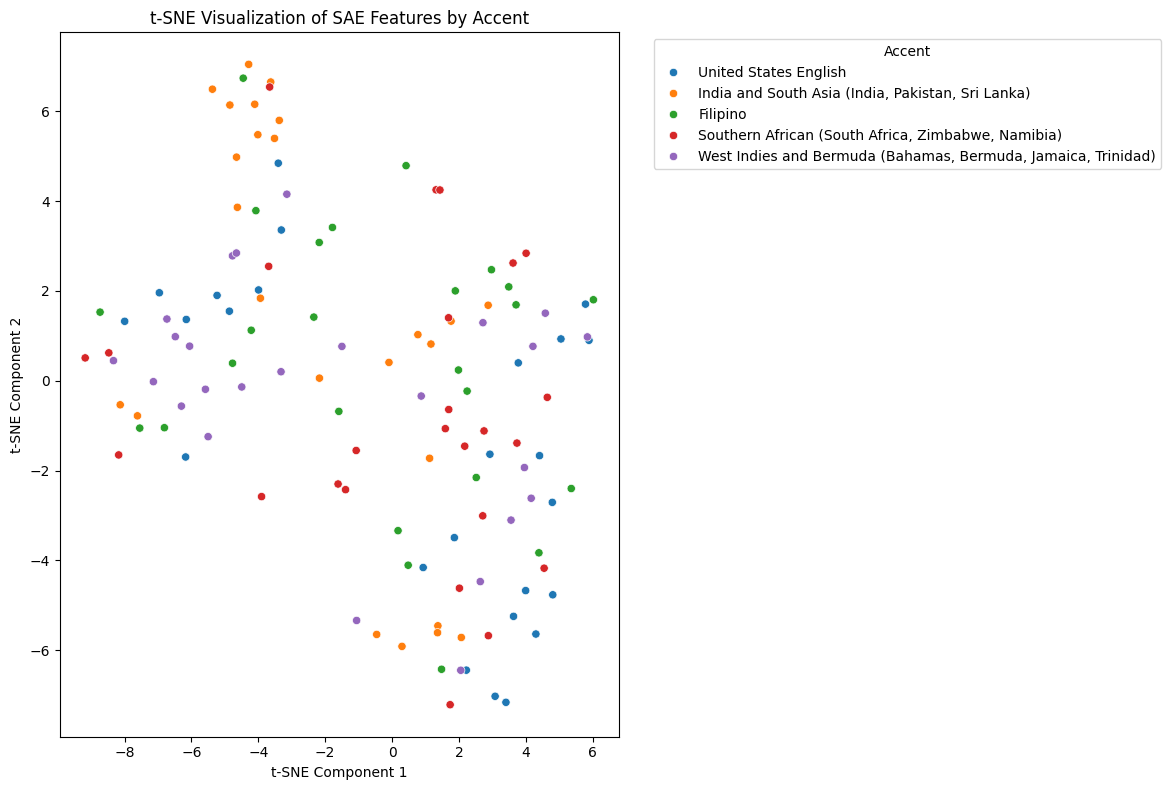

In [91]:
labels_array = labels_array.flatten()

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features_np)

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=features_2d[:, 0],
    y=features_2d[:, 1],
    hue=labels_array,
    palette='tab10',
    legend='full'
)
plt.title('t-SNE Visualization of SAE Features by Accent')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Accent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


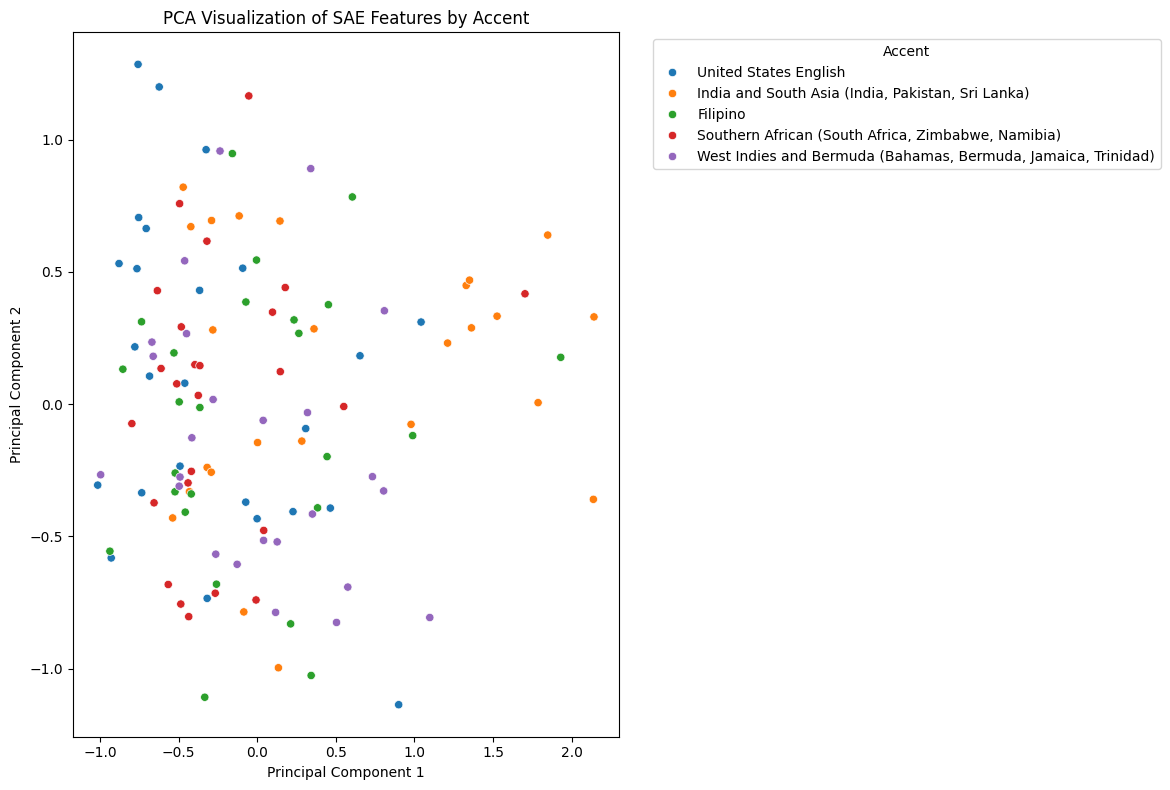

In [59]:
# Apply PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_np)

# Plot the PCA results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=features_pca[:, 0],
    y=features_pca[:, 1],
    hue=labels_array,
    palette='tab10',
    legend='full'
)
plt.title('PCA Visualization of SAE Features by Accent')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Accent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_55513/1697559250.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


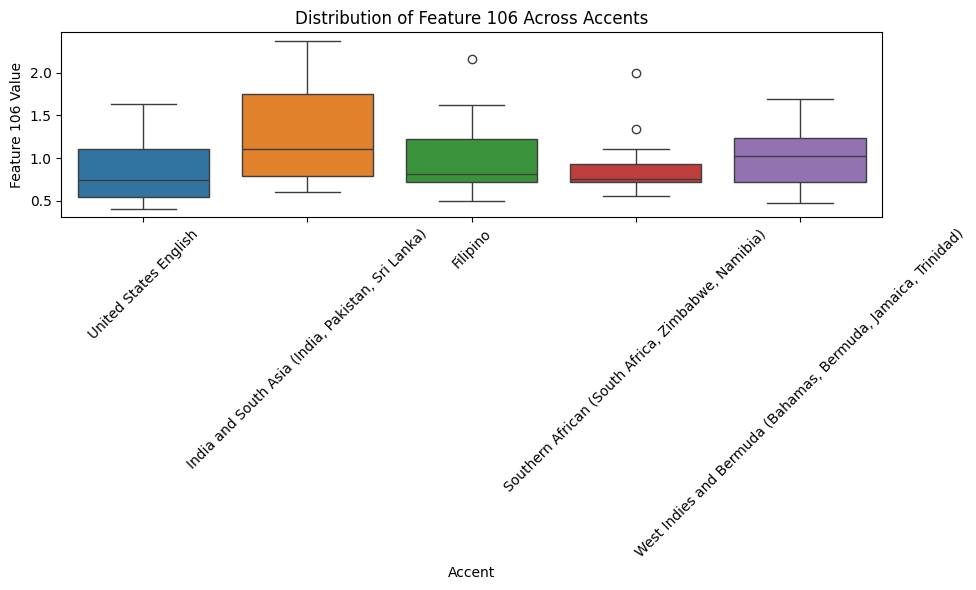

/tmp/ipykernel_55513/1697559250.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


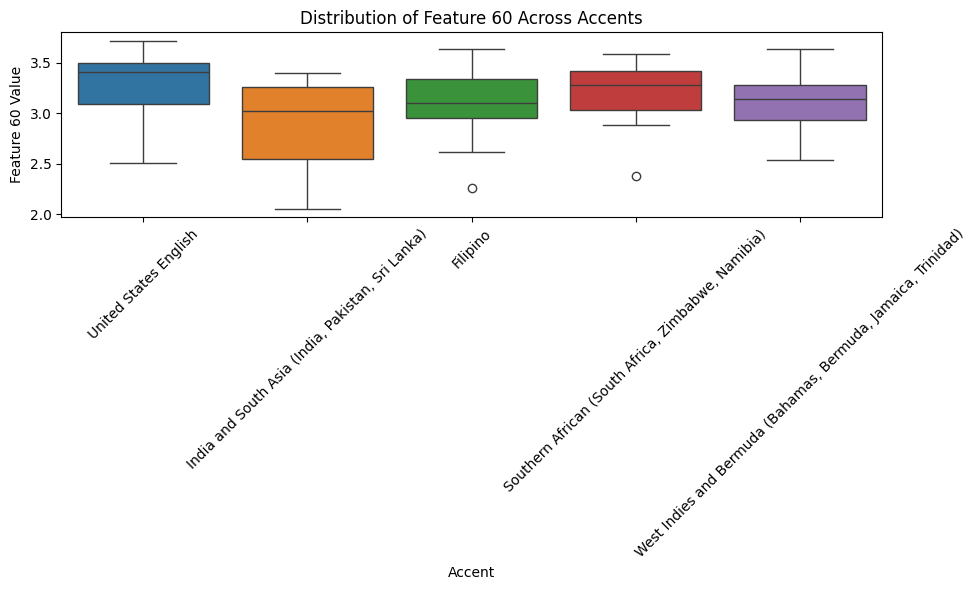

/tmp/ipykernel_55513/1697559250.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


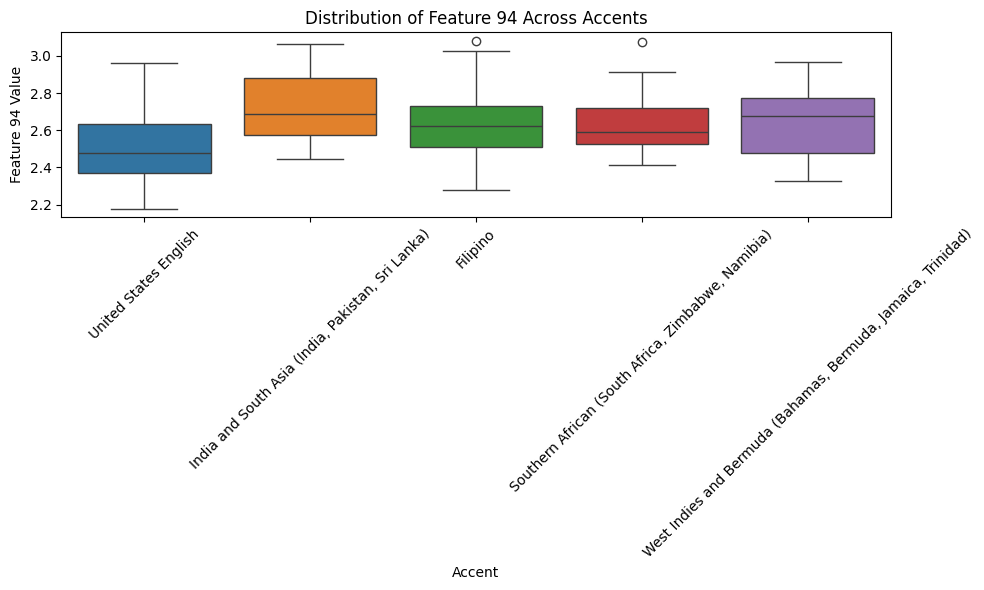

/tmp/ipykernel_55513/1697559250.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


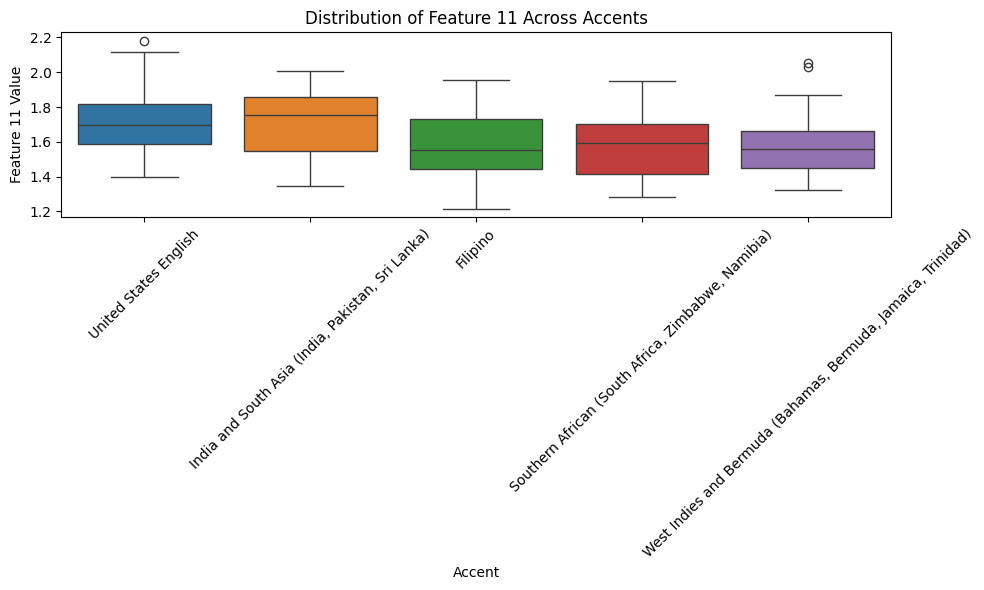

/tmp/ipykernel_55513/1697559250.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


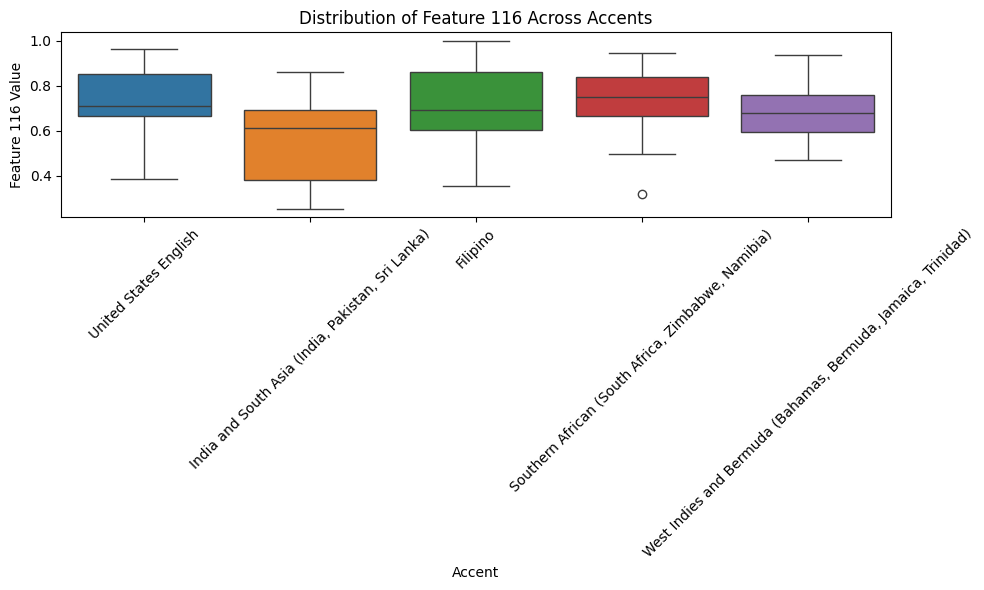

In [60]:
# Compute variance of features
feature_variances = np.var(features_np, axis=0)
# Get indices of top features
top_features_indices = feature_variances.argsort()[-5:][::-1]  # Top 5 features with highest variance
for feature_index in top_features_indices:
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x=labels_array.flatten(),
        y=features_np[:, feature_index],
        palette='tab10'
    )
    plt.title(f'Distribution of Feature {feature_index} Across Accents')
    plt.xlabel('Accent')
    plt.ylabel(f'Feature {feature_index} Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


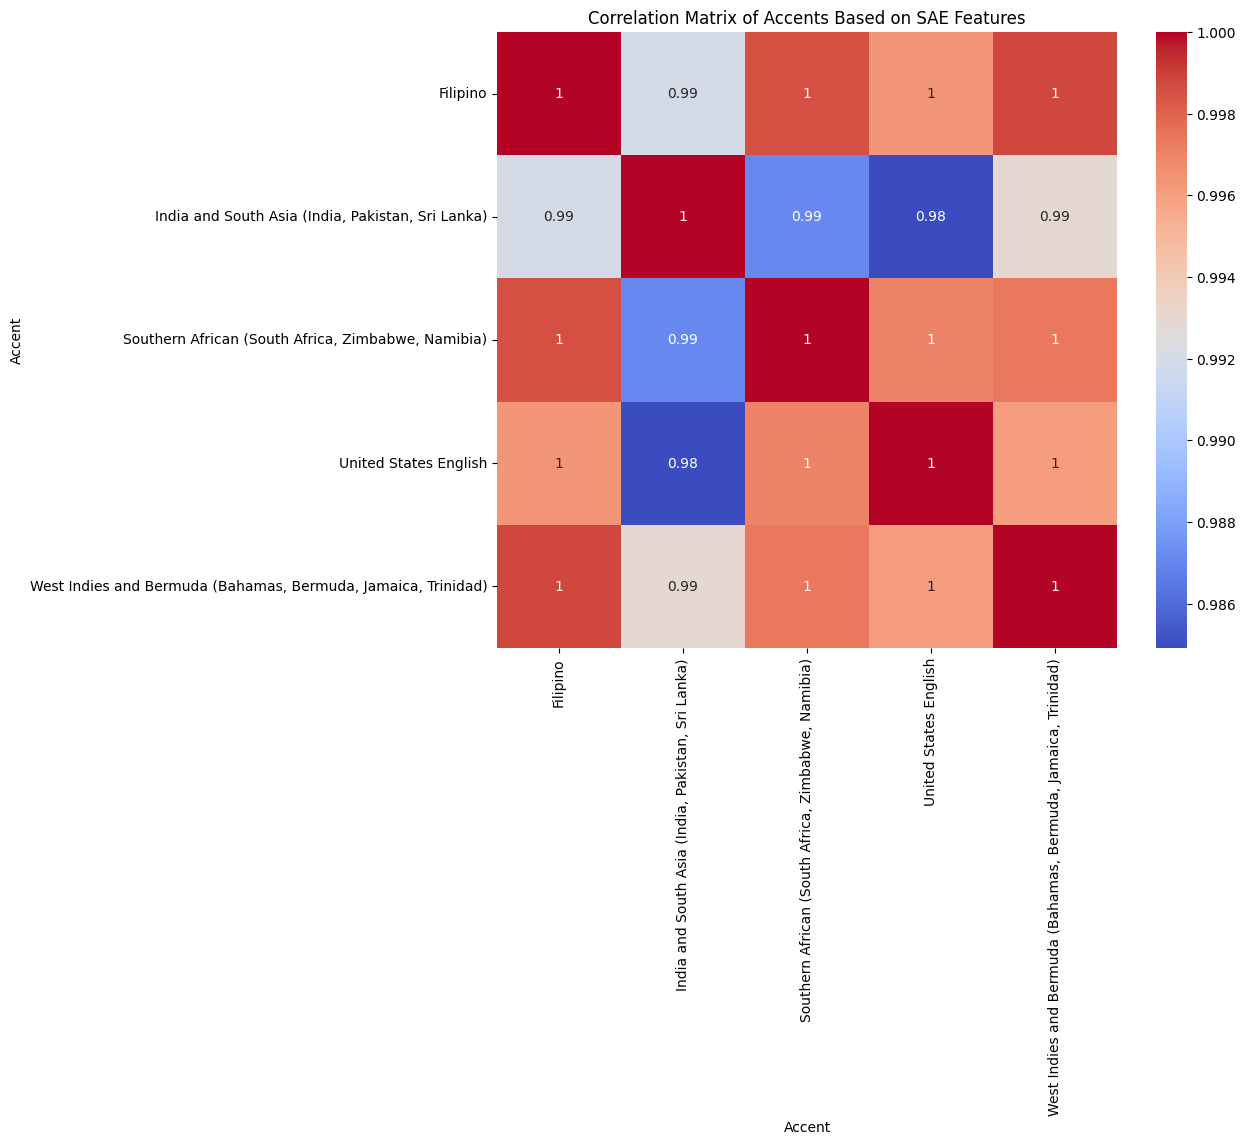

In [55]:
# Create a DataFrame with features and labels
df_features = pd.DataFrame(features_np, columns=[f'Feature_{i}' for i in range(features_np.shape[1])])
df_features['Accent'] = labels_array

# Compute the mean feature values per accent
accent_feature_means = df_features.groupby('Accent').mean()

# Compute the correlation matrix
corr_matrix = accent_feature_means.T.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=accent_feature_means.index, yticklabels=accent_feature_means.index)
plt.title('Correlation Matrix of Accents Based on SAE Features')
plt.xlabel('Accent')
plt.ylabel('Accent')
plt.show()


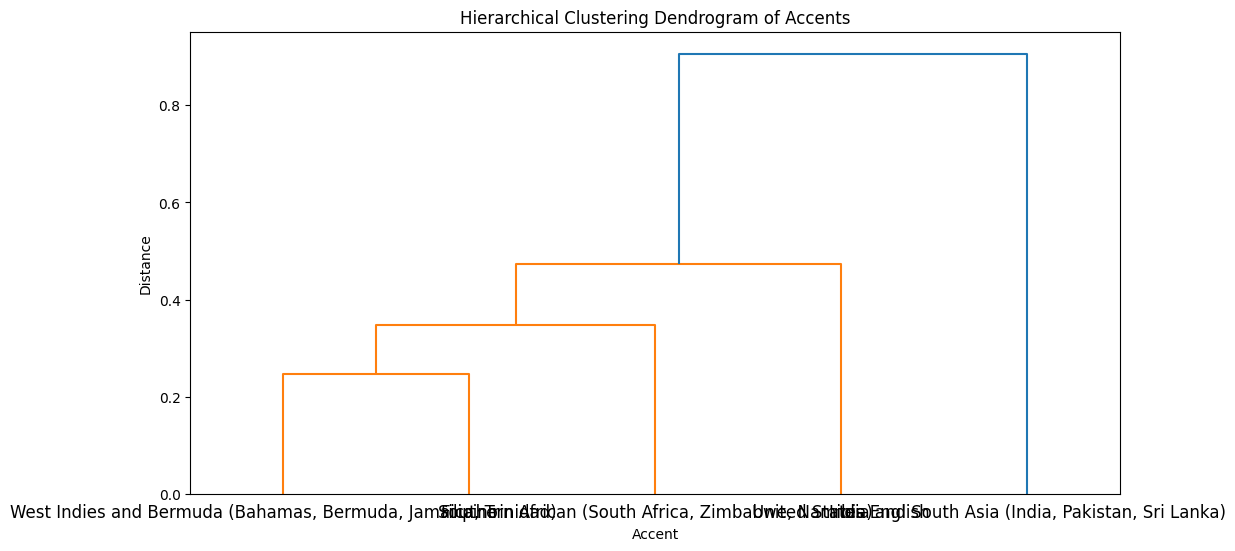

In [56]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute the linkage matrix
linked = linkage(accent_feature_means, 'ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    linked,
    labels=accent_feature_means.index.tolist(),
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title('Hierarchical Clustering Dendrogram of Accents')
plt.xlabel('Accent')
plt.ylabel('Distance')
plt.show()
